# Deep learning
---------------------------

This example shows how to use ATOM to train and validate a Convolutional Neural Network implemented with [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset whose goal is to classify handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [12]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(
        Conv2D(
            filters=64,
            kernel_size=3,
            activation="relu",
            input_shape=(28, 28, 1),
        )
    )
    model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(units=10, activation="softmax"))
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=1, batch_size=512, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym="NN", fullname="Neural network")

In [13]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [14]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

data = (X_train, y_train), (X_test, y_test)

## Run the pipeline

In [15]:
atom = ATOMClassifier(*data, n_rows=0.1, n_jobs=6, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 6 cores.

Dataset stats ====================== >>
Shape: (7000, (28, 28, 1), 2)
---------------------------------------
Train set size: 6000
Test set size: 1000
---------------------------------------
|    | dataset   | train     | test      |
|---:|:----------|:----------|:----------|
|  0 | 692 (1.2) | 595 (1.2) | 97 (1.4)  |
|  1 | 814 (1.4) | 693 (1.4) | 121 (1.7) |
|  2 | 703 (1.2) | 592 (1.2) | 111 (1.6) |
|  3 | 746 (1.3) | 647 (1.3) | 99 (1.4)  |
|  4 | 662 (1.1) | 560 (1.1) | 102 (1.4) |
|  5 | 581 (1.0) | 510 (1.0) | 71 (1.0)  |
|  6 | 673 (1.2) | 590 (1.2) | 83 (1.2)  |
|  7 | 733 (1.3) | 627 (1.2) | 106 (1.5) |
|  8 | 681 (1.2) | 575 (1.1) | 106 (1.5) |
|  9 | 715 (1.2) | 611 (1.2) | 104 (1.5) |



In [16]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
atom.head()

,Multidimensional feature,Target
0,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",2
1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",2
2,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",7
3,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",3
4,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",5


In [17]:
# Every row in the column contains the data of one image
print(f"Shape of one image: {atom.iloc[0, 0].shape}")
print(f"atom's shape (n_rows, (shape_image), n_cols): {atom.shape}")

Shape of one image: (28, 28, 1)
atom's shape (n_rows, (shape_image), n_cols): (7000, (28, 28, 1), 2)


In [18]:
# Like any other model, we can define custom dimensions for the bayesian optimization
dim = [Integer(1, 3, name="epochs"), Categorical([32, 64, 128, 256], name="batch_size")]

atom.run(model, metric="f1_weighted", n_calls=5, bo_params={"dimensions": dim, "cv": 1, "max_time": 120})


Training ===================================== >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
Initial point 1 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9733  Best f1_weighted: 0.9733
Time iteration: 13.505s   Total time: 13.510s
Initial point 2 ---------------------------------
Parameters --> {'epochs': 1, 'batch_size': 64}
Evaluation --> f1_weighted: 0.9467  Best f1_weighted: 0.9733
Time iteration: 5.392s   Total time: 18.925s
Initial point 3 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 64}
Evaluation --> f1_weighted: 0.9524  Best f1_weighted: 0.9733
Time iteration: 9.974s   Total time: 28.924s
Initial point 4 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9458  Best f1_weighted: 0.9733
Time iteration: 9.217s   Total time: 38.172s
Initial point 5 ---------------------------------
Parameters --> {'e

## Analyze the results

In [9]:
# Use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[3.3193524e-07, 5.8962629e-10, 8.7443772e-07, ..., 1.3339026e-06,
        9.2499363e-07, 1.3533815e-05],
       [9.9999058e-01, 1.8723382e-11, 9.3173858e-06, ..., 7.7003387e-10,
        4.8539359e-08, 4.6308526e-09],
       [6.7930179e-14, 5.5634137e-09, 9.0469169e-12, ..., 5.4167479e-09,
        1.3212116e-10, 6.2716066e-07],
       ...,
       [1.7736274e-10, 9.5250149e-14, 4.2735815e-13, ..., 7.2675728e-12,
        1.5567214e-07, 3.7829523e-06],
       [2.9188291e-06, 8.0337742e-12, 4.5623146e-08, ..., 5.2204485e-10,
        4.7253510e-13, 6.2878592e-13],
       [1.3656822e-06, 3.8385992e-09, 1.8453775e-05, ..., 1.7541604e-05,
        9.9955970e-01, 1.8250587e-04]], dtype=float32)

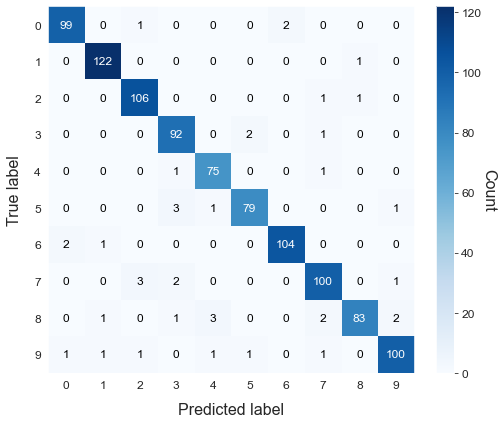

In [10]:
# Or make plots...
atom.nn.plot_confusion_matrix()